<a href="https://colab.research.google.com/github/jigyasa-kapoor20/LumbarSpineDegenerativeClassification/blob/main/Lumbar_Spine_Degenerative_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

zip_path = "/content/MRI_Data1.zip"
extract_path = "/content"


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Unzipped MRI_Data1")


✅ Unzipped MRI_Data1


In [ ]:
import os

root_dir = "/content/MRI_Data1"
print(sorted(os.listdir(root_dir))[:10])


['0001', '0002', '0003', '0004', '0005', '0007', '0009', '0010', '0011', '0012']


In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 34.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import pydicom
from PIL import Image
from tqdm import tqdm
from torchvision import models, transforms
import torch
from sklearn.cluster import KMeans

root_dir = "/content/MRI_Data1"
slice_folder_name = "T2_TSE_SAG_384_0002"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

resnet = models.resnet18(pretrained=True)
resnet.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet.fc = torch.nn.Identity()
resnet = resnet.to(device)
resnet.eval()

features = []
patient_ids = []

for folder in tqdm(sorted(os.listdir(root_dir))):
    path = os.path.join(root_dir, folder, slice_folder_name)
    if not os.path.exists(path): continue
    files = sorted(os.listdir(path))
    if not files: continue

    mid = len(files) // 2
    try:
        dcm = pydicom.dcmread(os.path.join(path, files[mid]))
        img = Image.fromarray(dcm.pixel_array).convert("L")
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            emb = resnet(img_tensor).cpu().numpy().flatten()

        features.append(emb)
        patient_ids.append(folder)
    except Exception as e:
        print(f"Skipping {folder}: {e}")

kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(np.array(features))
pseudo_grades = labels + 1

df = pd.DataFrame({
    "patient_id": [str(pid).zfill(4) for pid in patient_ids],
    "pfirrmann_grade": pseudo_grades
})
df.to_csv("labels.csv", index=False)
print("✅ Saved labels.csv")


100%|██████████| 456/456 [00:02<00:00, 170.96it/s]

✅ Saved labels.csv


In [ ]:
import pandas as pd

df = pd.read_csv("labels.csv")
print(df.head())
print(df['patient_id'].dtype)


   patient_id  pfirrmann_grade
0           1                2
1           2                1
2           3                1
3           4                3
4           5                3
int64


In [ ]:
root_dir = "/content/MRI_Data1"


In [ ]:
import os
print(os.listdir("/content/MRI_Data1"))

['0177', '0464', '0061', '0299', '0123', '0294', '0093', '0236', '0365', '0026', '0570', '0467', '0005', '0505', '0084', '0098', '0502', '0428', '0159', '0564', '0162', '0529', '0280', '0245', '0106', '0088', '0203', '0254', '0546', '0575', '0137', '0167', '0016', '0213', '0305', '0212', '0221', '0288', '0356', '0040', '0274', '0078', '0287', '0542', '0303', '0306', '0506', '0250', '0344', '0298', '0364', '0424', '0266', '0087', '0186', '0218', '0164', '0319', '0293', '0036', '0543', '0151', '0555', '0073', '0120', '0156', '0470', '0336', '0351', '0030', '0408', '0085', '0232', '0378', '0211', '0449', '0320', '0114', '0124', '0402', '0406', '0263', '0017', '0119', '0436', '0300', '0099', '0090', '0437', '0354', '0517', '0260', '0307', '0528', '0150', '0521', '0334', '0175', '0552', '0004', '0126', '0165', '0326', '0031', '0453', '0341', '0407', '0198', '0207', '0043', '0297', '0547', '0450', '0435', '0001', '0181', '0252', '0377', '0264', '0127', '0174', '0492', '0416', '0410', '0393',

In [ ]:
slice_folder_name = "T2_TSE_SAG_384_0002"

for patient_id in ['0032', '0287', '0283']:
    path = os.path.join(root_dir, patient_id, slice_folder_name)
    if os.path.exists(path):
        print(f"Found {slice_folder_name} for patient {patient_id}")
    else:
        print(f"Directory {slice_folder_name} not found for patient {patient_id}")


Found T2_TSE_SAG_384_0002 for patient 0032
Found T2_TSE_SAG_384_0002 for patient 0287
Found T2_TSE_SAG_384_0002 for patient 0283


In [ ]:
import os
print(os.path.exists('/content/MRI_Data1/543/T2_TSE_SAG_384_0002'))  # Should print True if the path exists


False


In [ ]:

df = pd.DataFrame({
    "patient_id": [str(pid).zfill(4) for pid in patient_ids],
    "pfirrmann_grade": pseudo_grades
})
df.to_csv("labels.csv", index=False)
print("✅ Saved labels.csv with padded patient IDs")


✅ Saved labels.csv with padded patient IDs


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

class PfirrmannMRIDataset(Dataset):
    def __init__(self, root_dir, label_file, transform=None, slices_per_patient=15):
        self.root_dir = root_dir
        self.labels_df = pd.read_csv(label_file, dtype={'patient_id': str})  # ✅ Ensure patient_id is string
        self.transform = transform
        self.slices = slices_per_patient

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        pid = str(self.labels_df.iloc[idx]['patient_id']).zfill(4)  # ✅ Zero pad to match folder names
        label = int(self.labels_df.iloc[idx]['pfirrmann_grade']) - 1
        path = os.path.join(self.root_dir, pid, slice_folder_name)
        image_stack = []

        try:
            files = sorted(os.listdir(path))[:self.slices]
        except FileNotFoundError:
            raise RuntimeError(f"❌ Folder not found: {path}")

        for f in files:
            dcm = pydicom.dcmread(os.path.join(path, f))
            img = Image.fromarray(dcm.pixel_array).convert("L")
            if self.transform:
                img = self.transform(img)
            image_stack.append(img)

        stack_tensor = torch.stack(image_stack)  # Shape: [S, C, H, W]
        return stack_tensor, label


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = PfirrmannMRIDataset(root_dir, "labels.csv", transform)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)
print("✅ Dataset and DataLoader ready")


✅ Dataset and DataLoader ready


In [ ]:
class SliceWiseCNN(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        base.fc = nn.Linear(base.fc.in_features, 5)
        self.base = base

    def forward(self, x):
        B, S, C, H, W = x.shape
        x = x.view(B * S, C, H, W)
        x = self.base(x)
        x = x.view(B, S, -1).mean(dim=1)
        return x


In [ ]:
def collate_fn(batch):
    max_slices = max([x[0].shape[0] for x in batch])
    padded_batch = []
    labels = []

    for img_tensor, label in batch:
        num_slices = img_tensor.shape[0]
        if num_slices < max_slices:
            padding = max_slices - num_slices
            padded_img = torch.cat([img_tensor, torch.zeros(padding, *img_tensor.shape[1:])], dim=0)
        else:
            padded_img = img_tensor
        padded_batch.append(padded_img)
        labels.append(label)

    imgs_tensor = torch.stack(padded_batch)
    labels_tensor = torch.tensor(labels)

    return imgs_tensor, labels_tensor


In [ ]:
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)


In [ ]:
model = SliceWiseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)  # [B, S, C, H, W]
        labels = labels.to(device)

        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 | Loss: 129.9381
Epoch 2 | Loss: 94.3935
Epoch 3 | Loss: 80.3675
Epoch 4 | Loss: 62.0396
Epoch 5 | Loss: 54.5997
Epoch 6 | Loss: 41.0455
Epoch 7 | Loss: 29.9062
Epoch 8 | Loss: 34.7345
Epoch 9 | Loss: 33.0227
Epoch 10 | Loss: 17.9429



Classification Report:
               precision    recall  f1-score   support

           0      1.000     0.987     0.993        76
           1      1.000     1.000     1.000       140
           2      0.994     1.000     0.997       157
           3      1.000     1.000     1.000        63
           4      1.000     1.000     1.000        20

    accuracy                          0.998       456
   macro avg      0.999     0.997     0.998       456
weighted avg      0.998     0.998     0.998       456



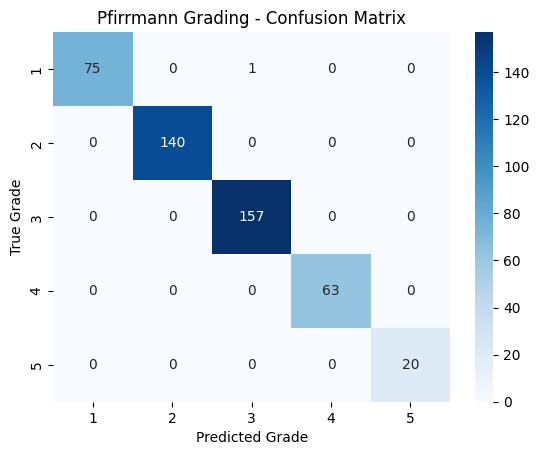

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds, all_targets = [], []

for imgs, labels in train_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_targets.extend(labels.cpu().numpy())

print("\nClassification Report:\n", classification_report(all_targets, all_preds, digits=3))

cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel("Predicted Grade")
plt.ylabel("True Grade")
plt.title("Pfirrmann Grading - Confusion Matrix")
plt.show()
